# Description
The purpose of this notebook is to explore the possible emergence of pyranopterin-dependent biochemistry via network expansion. 

### Load packages and run network expansion

In [45]:
import networkExpansionPy.lib as ne
import numpy as np
import pandas as pd
import pickle as pickle
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr,pearsonr,mannwhitneyu
from statsmodels.stats.multitest import multipletests
plt.rcParams['font.family'] = 'Arial'

import warnings
from scipy.sparse import (spdiags, SparseEfficiencyWarning, csc_matrix,
    csr_matrix, isspmatrix, dok_matrix, lil_matrix, bsr_matrix)
warnings.simplefilter('ignore',SparseEfficiencyWarning)


import re

def load_data(network_name):
    with open(ne.asset_path  + "/metabolic_networks/" + network_name,"rb") as filehandler:
        metabolism = pickle.load(filehandler)
    return metabolism


def tokenize_molecule(molecule):
    return re.findall('[A-Z][a-z]?|\d+|.', molecule)

def get_elements(molecule):
    return re.findall('[A-Z][a-z]?', molecule)

def mol_formula_dict(formula):
    elems = get_elements(formula)
    f_dict= {}
    for e in elems:
        s= '(?<={molecule})\d*'.format(molecule=e)
        z = re.findall(s,formula)
        z = z[0]
        if len(z) == 0:
            f_dict[e] = 1
        else:
            f_dict[e] = int(z)
    return f_dict


model_id = "../data/network-expansion/metabolism.v8.01May2023.pkl"
metabolism = pd.read_pickle(model_id)
cids = metabolism.coenzymes


# read in the pyranopterin gene table
mwpterins = pd.read_csv("../data/pyranopterin.geneTable.csv",index_col=0)
pterin_ko = [x.split(',') for x in mwpterins['KO (pterin domain)'].dropna().tolist()]
pterin_ko = list(set([item for sublist in pterin_ko for item in sublist]))

# load seed set
seed_set = pd.read_csv('../data/network-expansion/seed_set.csv')

# run network expansion
cx,rx = metabolism.expand(seed_set.ID.tolist(),algorithm="trace")


In [34]:



mo_mets = ['Z00031']
w_mets = ['Z00059']


wrxns = metabolism.network[metabolism.network.cid.isin(w_mets)][['rn','direction']].drop_duplicates()
wrxns = list(zip(wrxns['rn'].tolist(),wrxns['direction'].tolist()))

morxns = metabolism.network[metabolism.network.cid.isin(mo_mets)][['rn','direction']].drop_duplicates()
morxns = list(zip(morxns['rn'].tolist(),morxns['direction'].tolist()))


morxns_ = pd.DataFrame(pd.Series({x:y for x,y in rx.items() if x in morxns}))
wrxns_ = pd.DataFrame(pd.Series({x:y for x,y in rx.items() if x in wrxns}))
wrxns_.columns = ['iteration']
morxns_.columns = ['iteration']
wrxns_['coenzyme'] = "W"
morxns_['coenzyme'] = "Mo"
wm = pd.concat([morxns_,wrxns_],axis=0).reset_index()
wm = wm[wm['level_0'].apply(lambda x: 'RZ' not in x)]

wmo_iter = wm.reset_index()[["coenzyme","iteration"]]
wmo_iter.columns = ["metal","iteration"]

wmb = wm[wm["iteration"] < cx["C00007"]]
wmb["rn"] = wmb["level_0"].apply(lambda x: x.split("_")[0])
mo_rxns_pre_o2 = wmb[wmb["coenzyme"] == "Mo"].rn.tolist()
w_rxns_pre_o2 = wmb[wmb["coenzyme"] == "W"].rn.tolist()


wm["rid"] =wm["level_0"].apply(lambda x: x.split("_")[0])
wmr=wm.set_index("rid").join(mwpterins.set_index("Reaction"))
wmr = wmr[[x for x in list(wmr) if x != "level_0"]].drop_duplicates()
wmr = wmr[~wmr["KO (pterin domain)"].isna()]
wmr["KO (pterin domain)"] = wmr["KO (pterin domain)"].apply(lambda x: x.replace("K00203","K00201"))



/Users/joshuagoldford/opt/miniconda3/envs/ne.py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Text(0.5, 0, 'expansion iteration ($\\mathcal{I}_r$)')

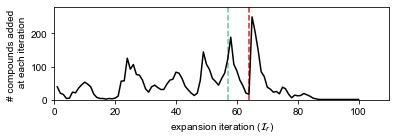

In [35]:
#mwpterins
MoPterin = 'Z00031'
WoPterin = 'Z00059'
cmap = sns.color_palette("Set1")
abundance = pd.DataFrame(pd.Series(cx),columns=['iter']).reset_index().groupby('iter').count()
abundance['compounds (cumulative)'] = abundance['index'].cumsum()

h = 6
rat = 4/14
#rat = 1/2
plt.figure(figsize=(h,rat*h))
sns.lineplot(x='iter',y='index',data=abundance.iloc[1:],color="black")

plt.ylabel('# compounds added \n at each iteration')
#plt.xlabel("expansion iteration")
plt.xlim([0,110])
plt.ylim([0,280])

cmap2 = sns.color_palette("Set2")
plt.vlines(cx['C00007'],0,280,cmap[0],"--")
plt.vlines(cx[MoPterin],0,280,cmap2[0],"--")

#plt.vlines(cx[WoPterin],0,280,cmap[2],"--")
#for i in zr.iteration.unique():
#    plt.vlines(i,0,280,"gray","--")

plt.xlabel('expansion iteration ($\mathcal{I}_r$)')


In [36]:
rxn_table = pd.read_csv("../data/network-expansion/reactionTable.csv",index_col=0)

In [37]:
zr = wmr[["iteration","Pterin"]].reset_index().groupby("index").min()
zrf = zr.join(rxn_table.set_index("reaction"))
zrf["name"] = zrf["name"].apply(lambda x: x.split(";")[0])

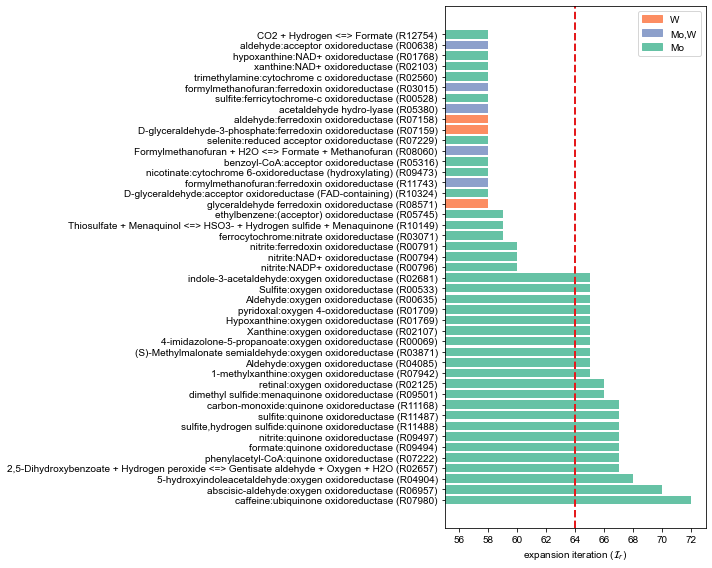

In [47]:
from matplotlib.ticker import MaxNLocator

# Read the data
data = zrf.copy()

# Create a color mapping for the Pterin_class
colors = sns.color_palette("Set2")
oxy_cmap = sns.color_palette("Set1")[0]
color_mapping = {
    "W": colors[1],
    "Mo,W": colors[2],  # same color as "W"
    "Mo": colors[0],   # for example, adjust as needed for other classes
    # ... add other classes as needed
}

data['color'] = data['Pterin'].map(color_mapping)
data = data.sort_values("iteration",ascending=False)

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))
for idx, row in data.iterrows():
    ax.barh(row["name"] + " (" + idx + ")", row['iteration'], color=row['color'])

# Setting the legend
handles = [plt.Rectangle((0,0),1,1, color=color_mapping[key]) for key in color_mapping]
ax.legend(handles, color_mapping.keys())

#ax.set_xlabel('Iteration')
ax.set_xlabel('expansion iteration ($\mathcal{I}_r$)')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

#ax.set_title("Expansion")
ax.axvline(x=cx["C00007"], color=oxy_cmap, linestyle='--', linewidth=2)

plt.tight_layout()
plt.xlim([55,73])
plt.show()


In [ ]:
y = pd.read_csv("../data/meanMoVsW.20k.23Nov2022.csv",index_col=0)

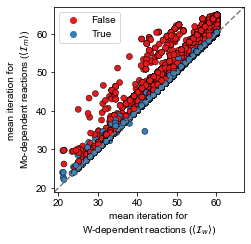

In [ ]:
plt.figure(figsize=(3.4,3.4))
g = sns.scatterplot(x='W',y='Mo',data=y,hue='oxygen',palette='Set1',edgecolor='k',legend=True,rasterized=True)
sns.lineplot(x=[19,67],y=[19,67],color='grey',linestyle='--')
plt.xlim([19,67])
plt.ylim([19,67])
plt.xlabel('mean iteration for \n' + r'W-dependent reactions ($\langle \mathcal{I}_w \rangle$)')
plt.ylabel('mean iteration for \n' + r'Mo-dependent reactions ($\langle \mathcal{I}_m \rangle$)')
#plt.ylabel(r'mean iteration for \n Mo-dependent reactions ($<\mathcal{I}_m>$)')
#plt.legend([])
plt.savefig("Fig1B.meanIterScatterplot.mcal.svg",dpi=400)

In [362]:
y['delta'] = y['Mo'] - y['W']

<Figure size 100.8x100.8 with 0 Axes>

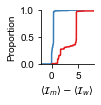

In [402]:
plt.figure(figsize=(1.4,1.4))
sns.displot(x='delta',hue='oxygen',data=y,kind='ecdf',palette='Set1',aspect=1,height=1.5,legend=False)
plt.xlim([-2,8])
plt.xlabel(r'$\langle \mathcal{I}_m \rangle - \langle \mathcal{I}_w \rangle$')
plt.savefig('Fig1B.inset.svg')